<a href="https://colab.research.google.com/github/sauddy/DPCNet/blob/main/DPCNet_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DPNNet-RT -- 22 October 2022 (Colab Compatible)

In this notebook we are using the data from the entire 700 simulations:

This notebook is created to build a ML model that can Classify the number of hidden planets and Predict the 
corresponding planet mass for each of the planet from the protoplanetary disk images directly


#####    Please note this version of the code is compatible with Google colab 

 

In [2]:
############################################# Mount the drive if running from Colab ##########################################
# from google.colab import drive
# drive.mount('/content/drive/')

### IDEA behind this notebook : 
#### Author : Sayantan 
#### Created : 3 Feb 2022
#### This notebook is adopted from the DPNNet-2.0

##### Updated1: 24 Feb 2022 to include multi-outputs
##### Updated2: 22 October 2022 to include the all the date from the 700 FARGO3D calculations

This notebook is developed to train the Model with RT images:
We want to perform the following set of tasks

 P.S.This is a modular notebook that does the following:
 1. Import all the customized Modules from Modules_DPNNet 
 2. For data processing we use RTdata_processing.py script 
 3. A functional module to call the different networks independently. (deep_models.py, other_cnn.py)
 4. On October 2022, we are updating this notebook. We can now acess the complete data but shall choose randomly from the images
 5. Still only considering the axysymmetric images




In [9]:
# import the necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import cv2
import os
import csv

## Modules to check the performance of the code
from time import process_time 
# !pip install memory_profiler ## When running from Google Colab
# import memory_profiler as mem_profile
# print('Memory (Before): {}Mb'.format(mem_profile.memory_usage()))


## Importing the necessary TesnorFLow modules modules
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score ## form calcualting the r2 score
from sklearn.utils import shuffle
from tensorflow import keras as k
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Trasfer Learning Models

from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1 
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5 
from tensorflow.keras.applications import EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import ResNet50,ResNet50V2


## Checking the availbale number of GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:",gpu.name,"Type:",gpu.device_type)
print("TensorFlow version used ",tf.__version__)


Num GPUs Available:  2
Name: /physical_device:GPU:0 Type: GPU
Name: /physical_device:GPU:1 Type: GPU
TensorFlow version used  2.9.0


In [3]:
############ Please provide the same path to the code directory if using Colab################

# Path_gdrive= '/content/drive/MyDrive/DPNNet-RT/' ## Comment out this line if using local computer

## Importing the Modules from Modules_DPNNet
import sys
try: ## tries to find the modules in the local directory first
  current_directory = os.getcwd()
  path = current_directory + '/' # For local computer 
#   path = '' # For local computer  
  sys.path.append(path+'MODULES_DPNNeT')
  import data_processing_RT as dp
  import deep_models as dm
  import other_cnns as ocn

########### Folders to save the processed data, files and figures when using Local computer ##############
  output_folder_list = ['data_folder','figures','saved_model']
  for file in output_folder_list:
    try:
        os.makedirs(file)
    except OSError:
        print ("Creation of the directory %s failed/ not needed as it already exit" % file)
    else:
        print ("Successfully created the directory %s" % file)
  
except ModuleNotFoundError:
  
  # #For Colab use:
  # #Point to the path containing the modules in the above section
  # # data folder are a directory above the directory containing the notebook
  try:
    path = Path_gdrive
    print(path)
    sys.path.append(path+'MODULES_DPNNeT')
    import data_processing_RT as dp
    import deep_models as dm
    import other_cnns as ocn

    ########### Folders to save the processed data, files and figures when using GDRIVE ##############
    import os
    os.chdir(path)
    print("Creating the folders")
    !mkdir -p data_folder
    !mkdir -p figures ## to save the figures
    !mkdir -p figures_paper
    !mkdir -p saved_model
  except ModuleNotFoundError:
    print("The path to the modules is incorrect-- Provide current path")

print("[INFO] Modules imported")



We are currently using the Modules_DPCNet-RT
Creation of the directory data_folder failed/ not needed as it already exit
Creation of the directory figures failed/ not needed as it already exit
Creation of the directory saved_model failed/ not needed as it already exit
[INFO] Modules imported


# Creating a csv with simulations params and path to each RT images

In [4]:
## Taking a look at the paramter file 
parameter_df = dp.load_parameter_csv(path)
parameter_df

,Planet_Mass1,Planet_Mass2,Planet_Mass3,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Flaring_Index,Rp1,Rp2,Rp3,a_grain_mic
0,0.000322,0.00204,0.001210,0.050,0.001,1.570000,0.0432,1.0,0.010,1.010,2.19,3.22,3000.0
1,0.002280,0.00154,0.000963,0.025,0.010,1.570000,0.0561,1.0,0.075,0.943,2.16,3.37,1000.0
2,0.002450,0.00262,0.002460,0.025,0.010,1.570000,0.0261,1.0,0.075,1.160,1.84,3.15,10000.0
3,0.000917,0.00195,0.001050,0.010,0.001,1.570000,0.0496,1.0,0.250,1.100,1.82,2.99,10000.0
4,0.001770,0.00187,0.002210,0.025,0.050,1.570000,0.0625,1.0,0.075,0.863,2.08,3.32,3000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0.002110,0.00000,0.000000,0.025,0.005,0.000157,0.0454,1.0,0.010,1.100,1.94,3.29,100.0
696,0.002530,0.00000,0.000000,0.025,0.010,0.000157,0.0882,1.0,0.075,0.851,1.99,3.10,100.0
697,0.000577,0.00000,0.000000,0.025,0.001,0.000157,0.0732,1.0,0.250,1.130,2.00,3.35,100.0
698,0.001940,0.00000,0.000000,0.025,0.050,0.000157,0.0711,1.0,0.075,0.966,2.02,3.32,100.0


## Move the images from the original folder to the code directory 

Only needed initially for moving the images to the working directory--
Ones the data is moved there is no need for this code block

In [5]:
############ to move the images from the original folder to the code directory ###################
## Path to the RT image folder
# RT_Folder_Path = "/Users/sauddy/OneDrive - Iowa State University/images/examples/"

# RT_Folder_Path = "/home/sauddy3/scratch/DPNNet-RT/radmc3d-2.0/examples/"


# list_RT_path = glob.glob(RT_Folder_Path+ 'RT_A*') ## make a list of all the RT folder where each folder is for each sim
# # print(list_RT_path)

# list_sorted_RT_path  = sorted(list_RT_path, key=lambda x: int(x.split('/')[7].split('_')[2])) ## sorting the images
# print(list_sorted_RT_path)

# ############### Moved the images to the code directory for convenience ######
# import shutil
# try:
#     os.mkdir('image_directory_complete')
# except OSError:
#      print ("Creation of the directory %s failed/ not needed as it already exit" % file)
# NEW_IMAGE_PATH = 'image_directory_complete'
# os.chdir(NEW_IMAGE_PATH)
# for index in range(len(list_sorted_RT_path)):
#     try:
#         os.mkdir('RT_A_'+ str(index+1))
#     except OSError:
# #          print ("Creation of the directory %s failed/ not needed as it already exit" % file)
#          pass
    
#     destination_path = 'RT_A_'+ str(index+1)
#     for img in glob.glob(list_sorted_RT_path[index] + "/images/snu/"+ "image_"+"*.png"):
#         shutil.copy(img, destination_path)

# os.chdir('../')

############## END ##############################

#### Address to the data folder 

Genrating the .csv file with the image address to load them later

In [6]:
############# Address to the data folder ###################

# ## updating the image paths once the transfer is done
list_RT_path = glob.glob(path+ 'image_directory_complete/'+ 'RT_A*') ## make a list of all the RT folder where each folder is for each sim

## When using the local M1
# list_sorted_RT_path  = sorted(list_RT_path, key=lambda x: int(x.split('/')[1].split('_')[2])) ## sorting the images


# ## For google colab this needs to be updated
list_sorted_RT_path  = sorted(list_RT_path, key=lambda x: int(x.split('/')[6].split('_')[2])) ## sorting the images


############## Will be removed once all the images are ready and tested ####
# print(list_sorted_RT_path)
# df_images_folder_complete=[]
# for index in range(len(list_sorted_RT_path)):

#     path_image = list_sorted_RT_path[index] ## path to each RT folder

#     ## for paths from the RT sim fodlers directly
#     list_image_path = glob.glob(path_image + "/images/snu/"+ "image_"+"*.png") ## list of the path to each image in the RT folder
#     if len(list_image_path) ==0 :## for updates image paths
#         # print("Reading images from the updated folder")
#         list_image_path = glob.glob(path_image+'/'+"*.png") ## list of the path to each image in the RT folder
#         print("index ={}, numberofimges ={}".format(index,len(list_image_path)))
#     df_images_folder =pd.DataFrame(list_image_path,columns=["image_path"])
#     df_images_folder_complete.append(df_images_folder)
    
    
# df_images_folder_complete = pd.concat(df_images_folder_complete, ignore_index=True, axis=0)
# df_images_folder_complete
# The idea is to generate a dataframe with the parameters and the path to the images




data_complete = dp.create_complete_data_csv(list_sorted_RT_path,path)
# data_complete
## Removing the nan if any
data_complete.isna().sum()  # summing the number of na
data_complete= data_complete.dropna()
data_complete

# data_complete['Planet_Count'] = (data_complete.loc[:, ['Planet_Mass1', 'Planet_Mass2', 'Planet_Mass3']] != 0).sum(axis=1)
data_complete = shuffle(data_complete,random_state=42)
data_complete= data_complete[:10000] ## Select less numbers of images for quick results
data_complete

[INFO]: Importing path for all the RT images
[INFO]: Contatinating the paths of all the RT images is now complete


,Planet_Mass1,Planet_Mass2,Planet_Mass3,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Flaring_Index,Rp1,Rp2,Rp3,a_grain_mic,image_path
77568,22.166667,60.000000,0.000000,0.050,0.0010,0.001570,0.0732,1.0,0.075,0.851,1.82,2.91,300.0,/scratch/sauddy3/DPNNet-RT/DPNNet-RT-ML-Code/i...
78688,363.333333,60.000000,240.000000,0.010,0.0010,0.001570,0.0818,1.0,0.010,0.909,2.16,3.03,300.0,/scratch/sauddy3/DPNNet-RT/DPNNet-RT-ML-Code/i...
70741,730.000000,60.000000,376.666667,0.025,0.0500,0.001570,0.0411,1.0,0.075,1.140,2.15,2.96,300.0,/scratch/sauddy3/DPNNet-RT/DPNNet-RT-ML-Code/i...
5447,703.333333,60.000000,516.666667,0.010,0.0050,1.570000,0.0732,1.0,0.250,1.150,2.05,3.06,1000.0,/scratch/sauddy3/DPNNet-RT/DPNNet-RT-ML-Code/i...
41656,930.000000,0.000000,0.000000,0.050,0.0001,0.015700,0.0989,1.0,0.010,0.931,2.05,3.46,3000.0,/scratch/sauddy3/DPNNet-RT/DPNNet-RT-ML-Code/i...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69041,420.000000,333.333333,460.000000,0.025,0.0001,0.001570,0.0946,1.0,0.075,1.150,2.00,3.37,100.0,/scratch/sauddy3/DPNNet-RT/DPNNet-RT-ML-Code/i...
38479,192.333333,0.000000,0.000000,0.025,0.0100,0.015700,0.0304,1.0,0.010,0.840,1.81,3.42,1000.0,/scratch/sauddy3/DPNNet-RT/DPNNet-RT-ML-Code/i...
92020,503.333333,60.000000,986.666667,0.025,0.0500,0.000157,0.0689,1.0,0.010,1.020,1.97,3.05,100.0,/scratch/sauddy3/DPNNet-RT/DPNNet-RT-ML-Code/i...
5466,703.333333,60.000000,516.666667,0.010,0.0050,1.570000,0.0732,1.0,0.250,1.150,2.05,3.06,1000.0,/scratch/sauddy3/DPNNet-RT/DPNNet-RT-ML-Code/i...


# Model Selections and Hyperparameters

In [7]:
#### Desired Image resoltuion  and Batch Size #####
X_res = Y_res = 128


## Select the kind of Traning ## Both can be selected as well
REG = True #True  ## When choosing regression
CLA = False #False #False #True  ## When Choosing Clasiffication


## Select the Network type

# NETWORK = "Vanilla" ## Cannot be uses at the moment
# NETWORK = "ALEXNET"
# NETWORK = "VGG"
# NETWORK = "RESNET50"

                                ########## When using Trasnfer Learning ######################
NETWORK = "TL"
transfer_model=ResNet50
# transfer_model=EfficientNetB3

## Hyper-Parameter to define
batch_size = 32 ## 20 was for regression ## the best was for 200 last run
valid_batch_size = 100
epochs=10 ## best was 100
init_lr = 1e-5 # 1e-5 (works for regression)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.2, patience=20, verbose=1, mode='min',restore_best_weights=True)



## Preparing data 

In [8]:
## partition the data csv file into training and testing splits using 85% of
## the data for training and the remaining 15% for testing
split = train_test_split(data_complete, test_size=0.15, random_state=42)
(train, test) = split

## Save the train and the test data for future use as well.
test.to_csv(path+'data_folder/test_dataset.csv')
train.to_csv(path+'data_folder/train_dataset.csv')

## Generate the Normalized data
normed_train_data, normed_test_data, train_labels, test_labels = dp.process_the_disk_attributes(train, test, path,multi_label=True)


[INFO] preparing the normalized data training/testing split...
Droping the irrelevant columns 
INFO: considering multiple planets as output
[INFO] Done...


### Loading the images 

In [9]:
import time
start = time.time()

if CLA == True:
        ### Preparing the dataset for the classification problem--- 
        ## For classification we included binary 1 or 0 depending on if the planet is present or not respectively
        train['Planet_Mass1'] = np.where(train['Planet_Mass1']!= 0, 1,0)
        train['Planet_Mass2'] = np.where(train['Planet_Mass2']!= 0, 1,0)
        train['Planet_Mass3'] = np.where(train['Planet_Mass3']!= 0, 1,0)
        # train = train.select_dtypes("string")
        test['Planet_Mass1'] = np.where(test['Planet_Mass1']!= 0, 1, 0)
        test['Planet_Mass2'] = np.where(test['Planet_Mass2']!= 0, 1, 0)
        test['Planet_Mass3'] = np.where(test['Planet_Mass3']!= 0, 1, 0)
        
        Y_train=train[['Planet_Mass1','Planet_Mass2','Planet_Mass3']] ## These are used as label for the non-generator training
        Y_test=test[['Planet_Mass1','Planet_Mass2','Planet_Mass3']]
        
        ###### Generate the training and the test images######
if X_res >= 128:
    
    def custom_augmentation(np_tensor):

        '''
        This function is used to crop the images when those are loaded using the 
        ImageDataGenerator Keras function. This custom augmentation function only
        works for three different res as given below. For other resolutions the 
        image needs to the cropped appropiately.

        '''

        # # # dimensions for cropping the image
        if X_res == 128:
          top,left,bottom,right = 20,25,110,90 
        if X_res == 256:          
          top,left,bottom,right = 40,50,220,180          
        if X_res == 512:
          top,left,bottom,right = 60,90,450,380          
                
        image = np.squeeze(np_tensor) 
        crop_image = image[top:bottom, left:right]
        crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
        crop_image = k.preprocessing.image.img_to_array(crop_image)
        return crop_image

    # datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,samplewise_center=True, samplewise_std_normalization=True,rescale=1./255.,validation_split=0.15)
    # datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,featurewise_center=True,featurewise_std_normalization=True,rescale=1./255.,validation_split=0.15)
    datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,rescale=1./255.,validation_split=0.15)

    #### TRAINING GENERATOR #####
    train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="image_path",
    y_col=["Planet_Mass1",'Planet_Mass2','Planet_Mass3'],
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(X_res,Y_res))

    #### VALIDATION GENERATOR #####
    validation_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="image_path",
    y_col=["Planet_Mass1",'Planet_Mass2','Planet_Mass3'],
    subset="validation",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(X_res,Y_res))

    #### TESTING GENERATOR #####
    test_datagen= k.preprocessing.image.ImageDataGenerator(preprocessing_function=custom_augmentation,rescale=1./255.)
    test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="image_path",
    y_col=["Planet_Mass1",'Planet_Mass2','Planet_Mass3'],
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(X_res,Y_res))
    
    
    ## STEP SIZES later used for training using generators
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

 

else:
    print("Uploading directly to RAM as the image resoltuion is manageble")
    trainImagesX = dp.load_disk_images(train, X_res, Y_res, Type = "Train")
    testImagesX = dp.load_disk_images(test, X_res, Y_res, Type = "Test")

Validation_split = 0.15 # 15 percent of the training data is used for validation
print('There are {} Train, {} Validation and {} Test images'.format(int((1-Validation_split)*len(normed_train_data)),int(Validation_split*len(normed_train_data)),len(normed_test_data)))## check the numbers in each category
end = time.time()
print("Total time elapsed =", end - start)

# Getting all memory using os.popen()
total_memory, used_memory, free_memory = map(
    int, os.popen('free -t -m').readlines()[-1].split()[1:])
 
# Memory usage
print("RAM memory % used:", round((used_memory/total_memory) * 100, 2))



Found 7225 validated image filenames.
Found 1275 validated image filenames.
Found 1500 validated image filenames.
There are 7225 Train, 1275 Validation and 1500 Test images
Total time elapsed = 0.4449899196624756
RAM memory % used: 4.46


### Checking image with cropping for verification

(32, 128, 128, 3)


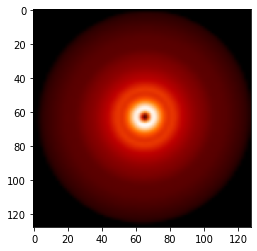

(32, 128, 128, 3)


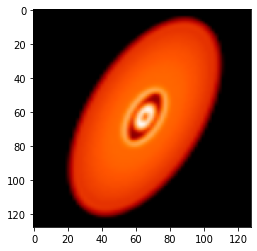

(32, 128, 128, 3)


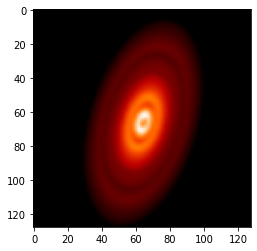

(32, 128, 128, 3)


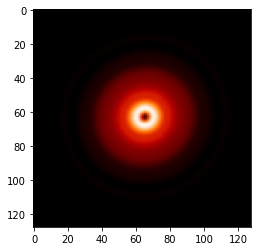

(32, 128, 128, 3)


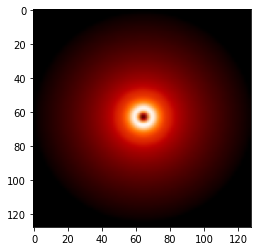

In [10]:
if X_res>= 128:
    for _ in range(5):
        img, label = train_generator.next()
        print(img.shape)   #  (1,256,256,3)
        plt.imshow(img[0])
        plt.show()
else:
    plt.imshow(trainImagesX[5])
    plt.show()

### Transfer Learning Codes

Will be later moved to the Module Folder

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


# modules added for the RESNET50
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import ZeroPadding2D, AveragePooling2D, GlobalMaxPooling2D, Add


def TRANSFERLEARNING(width,height,depth,classes=None,regress=False,multi_label=False,classification=False,option=None,transfer_model= None):

    '''
    This function introduces the use of Transfer learning to train the DPNNet Model
    Here we use the pretrained weights from the Imagenet data set
    
    Please note this here update the final layers to perform regress or classification
    or both regression and classification together
    
    Input:  1. Dimension of the image [width,height,depth]
            2. Number of classsification classes if used for calssification
            3. Regress on or off
            4. Multilabel -- True for multi-label regression Default == False
            5. Classification -- True or False 
            6. Option is the argument to use either softmax (default) or sigmoid for classification
            7. Select the transfer Learning Model from Either 3 RESNET50 or Efficientnet0-7 models
            
            
    Output : Model Build 
    
    '''
    
    ## Input layers
    X_input = layers.Input(shape=(X_res, Y_res, depth))
    x = X_input
    
    if transfer_model == None:
        transfer_model = EfficientNetB6
        print("Please Select the Network that will be used-- By Default {} will be used".format(str.lower(transfer_model.__name__)))
    
    #### Selecting the model along with the pretrained weights
    mod_name = transfer_model.__name__
    print("INFO: Keras Model used is {}".format(mod_name))
    print("Loading weights for {} since this notebook is not connected to internet".format(str.lower(mod_name)))
    
    try:
        model = transfer_model(include_top=False,input_tensor=x, weights='preloaded_weights/'+str.lower(mod_name)+'_notop.h5')
    except ValueError:
        model = transfer_model(include_top=False,input_tensor=x, weights='preloaded_weights/'+str.lower(mod_name)+'_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
    
    # Freeze the pretrained weights
    model.trainable = True

    # Rebuild top

    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    XX = Flatten()(x)
    XX = Dense(100, kernel_initializer='he_uniform', activation='relu')(XX) 
    # outputs = layers.Dense(classes, activation="softmax", name="pred")(x)


    if classification==True:
      # print("A new fully Connexted layer is added")
       ## Adding a Fully connected layer for classification
      Xclas = XX
      # Xclas = BatchNormalization(axis=1)(Xclas)   
      top_dropout_rate = 0.30
      # Xclas = layers.Dropout(top_dropout_rate, name="top_dropout1")(Xclas)  
      Xclas = Dense(50, kernel_initializer='he_uniform', activation='relu')(Xclas)
      Xclas = BatchNormalization(axis=1)(Xclas)
      # top_dropout_rate = 0.20
      # Xclas = layers.Dropout(top_dropout_rate, name="top_dropout2")(Xclas)
      Xclas = Dense(20, kernel_initializer='he_uniform', activation='relu')(Xclas)
      Xclas = BatchNormalization(axis=1)(Xclas)
        
      print("INFO:CNN is used for classification")
      if option ==1:
          print("Additional INFO:Using Softmax for classification")
          Xclas = Dense(units=classes,name='cla',activation='softmax')(Xclas) 
      else:  
          print("Additional INFO: Using Sigmoid activation for classification")
          Xclas = Dense(units=classes, name='cla',activation='sigmoid')(Xclas)
          out_clas = Xclas 


    if regress == True:
      print("INFO:CNN is used for regression")
      if multi_label==False:           
        Xreg = Dense(1, activation='linear', name='reg', kernel_initializer = glorot_uniform(seed=0))(XX)
      if multi_label==True: 
        ## 28 Feb 2022 added the multi-label output 
        print("INFO: Note Multiple Labels are optimised during regression")
        Xreg = Dense(3, activation='linear', name='reg', kernel_initializer = glorot_uniform(seed=0))(XX)
        out_reg = Xreg
    

    ### Create model

    if classification == True and regress == True:
      print("INFO: Performing both regression and classification -- Model Training")
      modelNEWCNN = Model(inputs = X_input,outputs=[out_reg, out_clas])
    elif regress == False:
      X = out_clas
      print("INFO: Classification Model is being trained")
      modelNEWCNN = Model(inputs = X_input, outputs = X)
    elif classification is False:
      X = out_reg
      print("INFO: Regression Model is being trained")
      modelNEWCNN = Model(inputs = X_input, outputs = X)

    return modelNEWCNN


## Training the CNN 

In [12]:

print('INFO: Currently training using the {} NETWORK with regression = {} and classification = {}'.format(NETWORK,REG,CLA))
if NETWORK == "Vanilla":
    CNN = dm.build_cnn(X_res, Y_res, 3, regress=True)
elif NETWORK == "ALEXNET":
    CNN = alexnet(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None)
elif NETWORK == "VGG":
    CNN = cnn_vgg(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None)
elif NETWORK == "RESNET50":
    # CNN = Resnet50(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None)
    CNN = ocn.Resnet50(X_res, Y_res, 3,classes=3,regress = REG,multi_label=True,classification=CLA,option=None)
elif NETWORK == "TL":    
    CNN = TRANSFERLEARNING(X_res, Y_res, 3,classes=3,regress = REG,multi_label=True,classification=CLA,option=None,transfer_model=transfer_model)

optimizer = tf.keras.optimizers.Adam(init_lr, decay=init_lr/epochs)


if REG == True and CLA ==False:
    CNN.compile(loss='mean_squared_error',
                    optimizer=optimizer,
                    metrics=['mean_absolute_error', 'mean_squared_error'])
    
    if X_res >= 128:
        print("INFO: REGRESSION using GENERATORS")       
        CNN_history = CNN.fit_generator(generator=train_generator,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=validation_generator,
                            validation_steps=STEP_SIZE_VALID,
                            epochs=epochs)
    else:

        CNN_history = CNN.fit(x=trainImagesX, y=train_labels,
                          validation_split = 0.15,epochs=epochs, batch_size=batch_size,callbacks=[early_stop])

if REG == False and CLA ==True:
    CNN.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    
    if X_res >= 128:          
        print("INFO: CLASSIFICATION using GENERATORS")  
        CNN_history = CNN.fit_generator(generator=train_generator,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=validation_generator,
                            validation_steps=STEP_SIZE_VALID,
                            epochs=epochs)
    else: 
        
        CNN_history = CNN.fit(x=trainImagesX, y=Y_train,
                      validation_split = 0.15,epochs=epochs, batch_size=batch_size,callbacks=[early_stop])

if REG == True and CLA ==True:
    # When used for classification and regression
    CNN.compile(loss=['mean_squared_error','binary_crossentropy'],optimizer=optimizer,metrics=['mean_squared_error', 'accuracy'])

    CNN_history = CNN.fit(x=X_train, y=[train_labels,Y_train],
                      validation_split = 0.15,epochs=epochs, batch_size=batch_size,callbacks=[early_stop])
# Getting all memory using os.popen()


total_memory, used_memory, free_memory = map(
int, os.popen('free -t -m').readlines()[-1].split()[1:])

# Memory usage
print("RAM memory % used:", round((used_memory/total_memory) * 100, 2))
# print('Memory (After Training): {}Mb'.format(mem_profile.memory_usage()))

INFO: Currently training using the TL NETWORK with regression = True and classification = False
INFO: Keras Model used is ResNet50
Loading weights for resnet50 since this notebook is not connected to internet


2022-11-01 14:59:04.206426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 14:59:04.874246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11319 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0, compute capability: 6.0


INFO:CNN is used for regression
INFO: Note Multiple Labels are optimised during regression
INFO: Regression Model is being trained
INFO: REGRESSION using GENERATORS


/tmp/ipykernel_12120/529158579.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  CNN_history = CNN.fit_generator(generator=train_generator,


Epoch 1/10


2022-11-01 14:59:17.676172: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2022-11-01 14:59:18.154792: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-01 14:59:18.157800: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-01 14:59:18.157881: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-01 14:59:18.160506: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-01 14:59:18.160597: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


225/225 [==============================] - 255s 1s/step - loss: 222188.7500 - mean_absolute_error: 345.4712 - mean_squared_error: 222188.7500 - val_loss: 230522.1094 - val_mean_absolute_error: 351.6309 - val_mean_squared_error: 230522.1094
Epoch 2/10
225/225 [==============================] - 97s 432ms/step - loss: 207215.2188 - mean_absolute_error: 334.1493 - mean_squared_error: 207215.2188 - val_loss: 230132.3594 - val_mean_absolute_error: 351.9295 - val_mean_squared_error: 230132.3594
Epoch 3/10
225/225 [==============================] - 83s 368ms/step - loss: 191828.4531 - mean_absolute_error: 321.8676 - mean_squared_error: 191828.4531 - val_loss: 219852.0469 - val_mean_absolute_error: 342.1068 - val_mean_squared_error: 219852.0469
Epoch 4/10
225/225 [==============================] - 83s 367ms/step - loss: 178052.3594 - mean_absolute_error: 309.9807 - mean_squared_error: 178052.3594 - val_loss: 173019.0312 - val_mean_absolute_error: 298.7804 - val_mean_squared_error: 173019.0312
E

## Saving the network and the loss history for future use

In [31]:
hist_df = pd.DataFrame(CNN_history.history)  ## converting to dataframe for future usels
## Saving the history and the model
if NETWORK == "TL":
    if REG == True and CLA == True:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelRC')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelRC'+'_history.csv')
    elif REG == True and CLA == False:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelR')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelR'+'_history.csv')    
    elif CLA == True and REG == False:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelC')        
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelC'+'_history.csv')
    
else:    

    if REG == True and CLA == True:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_modelRC'+'_history.csv')
    elif REG == True and CLA == False:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelR')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_modelR'+'_history.csv')    
    elif CLA == True and REG == False:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelC')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_modelC'+'_history.csv')

KeyboardInterrupt: 

# Loading the model

In [9]:
# Loading the model

if NETWORK == "TL":
    if REG == True and CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelRC')
    elif REG == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelR')
    elif CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelC')
        
    print("INFO:The Trained model {} at res {} is loaded ".format(NETWORK+'_'+str( transfer_model.__name__),str(X_res)))
else:
    if REG == True and CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC')
    elif REG == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelR')
    elif CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelC')



# CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC')
#Check its architecture
# CNN.summary()

2022-11-01 15:33:51.514047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 15:33:52.111950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11319 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0, compute capability: 6.0


INFO:The Trained model TL_ResNet50 at res 128 is loaded 


### Model Predictions and Results for the regression and Classification


In [15]:
test_index = 41 # 550  #550 ##210
if X_res >= 128:

    test_generator.reset()
    pred_CNN=CNN.predict_generator(test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1)
else:
    
    pred_CNN = CNN.predict(testImagesX)  
pred_CNN[test_index]



/tmp/ipykernel_12120/1800549803.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_CNN=CNN.predict_generator(test_generator,


46/46 [==============================] - 182s 4s/step


array([193.20334, 181.10823, 241.14604], dtype=float32)

In [16]:
# plt.imshow(testImagesX[test_iclass_mode)
if REG == True:
    print("The predicted Values are {} and \nThe True values are \n{} ".format(pred_CNN[test_index],test_labels.iloc[test_index]))
elif CLA == True:
    print("The predicted prbability of the presence of planets are {} and \nThe True values are \n{} ".format(pred_CNN[test_index],Y_test.iloc[test_index]))
    print("The predicted Values are {} and \nThe True values are \n{} ".format(pred_CNN[test_index],test_labels.iloc[test_index]))
    


The predicted Values are [193.20334 181.10823 241.14604] and 
The True values are 
Planet_Mass1     79.000000
Planet_Mass2    513.333333
Planet_Mass3    570.000000
Name: 46236, dtype: float64 


In [17]:
# CNN_history.history
# Y_test.iloc[test_index]

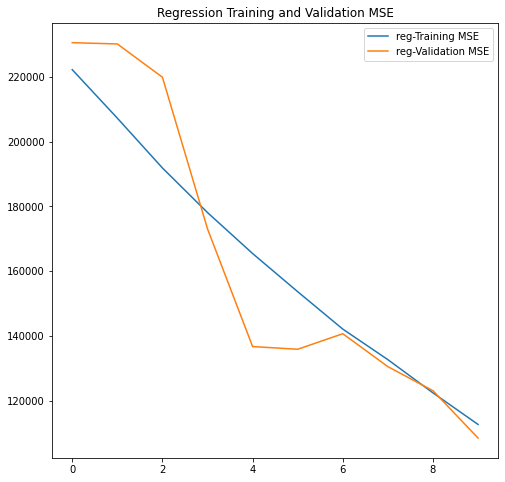

<Figure size 432x288 with 0 Axes>

In [18]:
# CNN_history.history ##val_fc_mean_squared_error val_fc_accuracy' val_dense_3_mean_squared_error val_dense_3_accuracy

###fc_mean_squared_error fc_accuracy dense_3_mean_squared_error dense_3_accuracy
hist =pd.DataFrame(CNN_history.history)
hist['epoch'] = hist.index = hist.index
hist
if NETWORK == "TL":
    plot_name = NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)
else:
    plot_name = NETWORK+'_'+str(X_res)
if  CLA == True and REG== False:
    cla_acc = CNN_history.history['accuracy']
    val_cla_acc = CNN_history.history['val_accuracy']
    cla_loss =CNN_history.history['loss']
    val_cla_loss = CNN_history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    # plt.subplot(2, 2, 1)
    plt.plot(hist['epoch'], cla_acc, label='cla-Training Accuracy')
    plt.plot(hist['epoch'], val_cla_acc, label='cla-Validation Accuracy')
    
    plt.legend(loc='upper right')
    plt.title('Classification Training and Validation Accuracy')
    plt.savefig('figures/'+plot_name+'_c.png')
    plt.show()
    
if REG == True and CLA == False:
    ## For Regression
    reg_mse = CNN_history.history['mean_squared_error']
    val_reg_mse =CNN_history.history['val_mean_squared_error']
    reg_loss =CNN_history.history['loss']
    val_reg_loss = CNN_history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    # plt.subplot(2, 2, 1)
    # plt.ylim(0,50000)
    plt.plot(hist['epoch'], reg_mse, label='reg-Training MSE')
    plt.plot(hist['epoch'], val_reg_mse, label='reg-Validation MSE')
    plt.legend(loc='upper right')
    plt.title('Regression Training and Validation MSE')
    plt.show()
    plt.savefig('figures/'+plot_name+'_r.png')

if REG == True and CLA == True:
    ## For classification
    cla_acc = CNN_history.history['cla_accuracy']
    val_cla_acc = CNN_history.history['val_cla_accuracy']
    cla_loss =CNN_history.history['cla_loss']
    val_cla_loss = CNN_history.history['val_cla_loss']

    ## For Regression
    reg_mse = CNN_history.history['reg_mean_squared_error']
    val_reg_mse =CNN_history.history['val_reg_mean_squared_error']
    reg_loss =CNN_history.history['reg_loss']
    val_reg_loss = CNN_history.history['val_reg_loss']
    
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(hist['epoch'], cla_acc, label='cla-Training Accuracy')
    plt.plot(hist['epoch'], val_cla_acc, label='cla-Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Classification Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(hist['epoch'], reg_mse, label='reg-Training MSE')
    plt.plot(hist['epoch'], val_reg_mse, label='reg-Validation MSE')
    plt.legend(loc='upper right')
    plt.title('Regression Training and Validation MSE')
    plt.savefig('figures/'+plot_name+'_cr.png')

